## Alias-Free-GAN

Generate Images

In [1]:
import torch
from torchvision import utils
import cv2
from tqdm import tqdm
import numpy as np

import os
import torch
import matplotlib.pyplot as plt

from stylegan2.model import PixelNorm, EqualLinear, EqualConv2d
from stylegan2.op import conv2d_gradfix, upfirdn2d, fused_leaky_relu

In [3]:
from model import Generator
from config import GANConfig

device = "cuda"
n_img = 16
n_row = 4
truncation = 0.5
truncation_mean = 4096
n_frame = 120
radius = 30
ckpt = 'jugyeong-30k.pt'

ckpt = torch.load(ckpt, map_location=lambda storage, loc: storage)
conf = GANConfig(**ckpt["conf"])
generator = conf.generator.make().to(device)
generator.load_state_dict(ckpt["g_ema"], strict=False)
#generator.eval()

<All keys matched successfully>

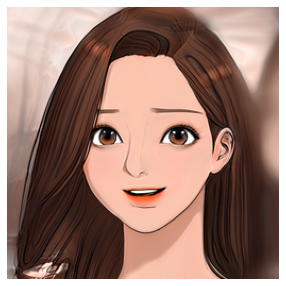

In [12]:
from utils import imshow, tensor2image

truncation = 0.4
trunc = generator.mean_latent(4096).detach().clone()

x = torch.randn(1, conf.generator["style_dim"], device=device)


img1 = generator(
    x,
    truncation=truncation,
    truncation_latent=trunc,
    input_is_latent=False
)

imshow(tensor2image(img1))

In [14]:
mean_latent = generator.mean_latent(truncation_mean)
x = torch.randn(n_img, conf.generator["style_dim"], device=device)

theta = np.radians(np.linspace(0, 360, n_frame))
x_2 = np.cos(theta) * radius
y_2 = np.sin(theta) * radius

trans_x = x_2.tolist()
trans_y = y_2.tolist()

images = []

transform_p = generator.get_transform(
    x, truncation=truncation, truncation_latent=mean_latent
)

with torch.no_grad():
    for i, (t_x, t_y) in enumerate(tqdm(zip(trans_x, trans_y), total=n_frame)):
        transform_p[:, 2] = t_y
        transform_p[:, 3] = t_x

        img = generator(
            x,
            truncation=truncation,
            truncation_latent=mean_latent,
            transform=transform_p,
        )
        images.append(
            utils.make_grid(
                img.cpu(), normalize=True, nrow=n_row
            )
            .mul(255)
            .permute(1, 2, 0)
            .numpy()
            .astype(np.uint8)
        )

videodims = (images[0].shape[1], images[0].shape[0])
fourcc = cv2.VideoWriter_fourcc(*"XVID")
video = cv2.VideoWriter("sample/sample.mp4", fourcc, 24, videodims)

for i in tqdm(images):
    video.write(cv2.cvtColor(i, cv2.COLOR_RGB2BGR))

video.release()

100%|██████████| 120/120 [00:02<00:00, 44.84it/s]


In [17]:
from IPython.display import HTML
from base64 import b64encode

mp4 = open(f'sample/sample.mp4','rb').read()

data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""
<video width=700 controls>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)

In [19]:
os.system(f"ffmpeg -i sample/sample.mp4 \
            -y -f gif -vf 'fps=15.0, split[s0][s1];[s0]palettegen[p];[s1][p]paletteuse[pp]' \
           sample/sample.gif")

0